In [43]:
using Pkg 
Pkg.activate(".")
Pkg.instantiate()
ENV["DATADEPS_ALWAYS_ACCEPT"] = true
SHOW_PROGRESS_BAR = true

  Activating project at `~/GIC-quAI-QRC/qrc_polyp_julia`


true

In [44]:
using MLDatasets
using MultivariateStats
using OneHotArrays
using Flux
using Bloqade
using Colors
using ProgressBars
using JLD2
using Plots
using ImageShow
using Images
using FileIO
using ImageTransformations
using Random
using MLUtils

# Load the Generated Polyp Dataset

In [45]:
function create_polyp_dataset(polyp_dir, no_polyp_dir; split_ratio=0.8, target_size=(28, 28))
    # Load and process polyp images
    polyp_files = readdir(polyp_dir, join=true)
    no_polyp_files = readdir(no_polyp_dir, join=true)
    
    # Shuffle files
    Random.seed!(42) 
    shuffle!(polyp_files)
    shuffle!(no_polyp_files)
    
    # Define train/test split
    n_polyp_train = floor(Int, length(polyp_files) * split_ratio)
    n_no_polyp_train = floor(Int, length(no_polyp_files) * split_ratio)
    
    polyp_train = polyp_files[1:n_polyp_train]
    polyp_test = polyp_files[n_polyp_train+1:end]
    no_polyp_train = no_polyp_files[1:n_no_polyp_train]
    no_polyp_test = no_polyp_files[n_no_polyp_train+1:end]
    
    # Create train dataset
    train_files = vcat(polyp_train, no_polyp_train)
    train_targets = vcat(ones(Int, length(polyp_train)), zeros(Int, length(no_polyp_train)))
    
    # Create test dataset
    test_files = vcat(polyp_test, no_polyp_test)
    test_targets = vcat(ones(Int, length(polyp_test)), zeros(Int, length(no_polyp_test)))
    
    # Shuffle train and test data
    train_indices = shuffle(1:length(train_files))
    test_indices = shuffle(1:length(test_files))
    
    train_files = train_files[train_indices]
    train_targets = train_targets[train_indices]
    test_files = test_files[test_indices]
    test_targets = test_targets[test_indices]
    
    # Process images and create features arrays (the features are the pixel values)
    function process_images(files, target_size)
        n_samples = length(files)
        features = zeros(Float32, target_size[1], target_size[2], n_samples)
        
        for (i, file) in enumerate(files)
            img = load(file)
            # Convert to grayscale if needed
            if eltype(img) <: Colorant
                img = Gray.(img)
            end
            # Resize
            img_resized = imresize(img, target_size)
            # Normalize to [0,1] and convert to features array
            features[:, :, i] = Float32.(img_resized)
        end
        
        return features
    end
    
    # Process train and test images
    train_features = process_images(train_files, target_size)
    test_features = process_images(test_files, target_size)
    
    # Create metadata
    train_metadata = Dict{String, Any}(
        "n_samples" => length(train_files),
        "n_polyp" => length(polyp_train),
        "n_no_polyp" => length(no_polyp_train),
    )
    
    test_metadata = Dict{String, Any}(
        "n_samples" => length(test_files),
        "n_polyp" => length(polyp_test),
        "n_no_polyp" => length(no_polyp_test),
    )
    
    # Create dataset structs
    train_dataset = (
        metadata = train_metadata,
        split = :train,
        features = train_features,
        targets = train_targets
    )
    
    test_dataset = (
        metadata = test_metadata,
        split = :test,
        features = test_features,
        targets = test_targets
    )
    
    return train_dataset, test_dataset
end

create_polyp_dataset (generic function with 1 method)

In [46]:
#=
dataset polyp:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :train
  features  =>    128×128×71030 Array{Float32, 3}
  targets   =>    71030-element Vector{Int64}
=#

root_dir = dirname(@__DIR__)
# Define the path to the generated polyp dataset
generated_polyp_dataset = joinpath(root_dir, "data", "datasets", "cvc_clinic_db_patches")
polyp_dir = joinpath(generated_polyp_dataset, "polyp")
no_polyp_dir = joinpath(generated_polyp_dataset, "no_polyp")

data_train, data_test = create_polyp_dataset(polyp_dir, no_polyp_dir; split_ratio=0.8, target_size=(128, 128))


((metadata = Dict{String, Any}("n_samples" => 1598, "n_no_polyp" => 798, "n_polyp" => 800), split = :train, features = [0.28235295 0.28235295 … 0.043137256 0.043137256; 0.3019608 0.30588236 … 0.043137256 0.043137256; … ; 0.043137256 0.043137256 … 0.039215688 0.039215688; 0.043137256 0.043137256 … 0.047058824 0.047058824;;; 0.050980393 0.05490196 … 0.043137256 0.047058824; 0.19215687 0.19607843 … 0.047058824 0.047058824; … ; 0.34117648 0.33333334 … 0.043137256 0.043137256; 0.3372549 0.34117648 … 0.043137256 0.043137256;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.30588236 0.3254902 … 0.043137256 0.043137256; 0.33333334 0.3372549 … 0.043137256 0.043137256; … ; 0.10980392 0.101960786 … 0.043137256 0.043137256; 0.11372549 0.10980392 … 0.043137256 0.043137256], targets = [1, 0, 1, 0

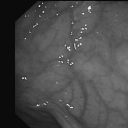

In [47]:
# plot random image of the training dataset
n = rand(1:size(data_train.features, 3))
img = data_train.features[:, :, n]
Gray.(img)

# PCA Reduction

In [48]:
# Print data_train's shape
println("data_train.features shape: ", size(data_train.features))
# Dataset dataset_length
dataset_length = size(data_train.features, 3)

image_dim = size(data_train.features, 1)
image_size = size(data_train.features, 2) * size(data_train.features, 1)

data_train.features shape: (128, 128, 1598)


16384

In [49]:
#=
The data_train and data_test are currently in the form 128x128x1x71030 and 128x128x1x17758 respectively.

We need to flatten the images in order to use them in the PCA algorithm.
The images are 128x128 pixels, and we need to convert them to a 16384-dimensional vector (128*128=16384).
=#

# Number of images
dataset_length = size(data_train.features, 3)

# Number of pixels in each image
image_size = size(data_train.features, 1) * size(data_train.features, 2)

# Flattened images
println("Flattening images...")
data_train_flat = reshape(data_train.features, (image_size, dataset_length))

# Number of principal components
dim_pca = 8

# The 'fit' function from the 'MultivariateStats' package generates the projection operator for the PCA
println("Fitting PCA model...")
model_pca = fit(PCA, data_train_flat, maxoutdim=dim_pca)

# Compute the first 8 principal components
println("Computing PCA...")
x = predict(model_pca, data_train_flat)

num_examples = 1000
xs = x[:, 1:num_examples]

Flattening images...
Fitting PCA model...
Computing PCA...


8×1000 Matrix{Float32}:
  -2.73739     5.91723   -17.0842   …  -7.10588    -6.02881      1.30803
 -28.2138     -9.18983     4.85625     -0.0562671   0.0400593  -17.0262
  -0.51764   -15.6315     -1.93086      5.07845    12.1639       1.22156
  -0.468572   -1.02832     8.38195     -3.73049     0.0280939   -4.8968
  -4.38882    -0.595982   -2.24836     -0.825041    1.80728     -1.23836
   1.83123     5.6861      3.18176  …   2.86305    -0.537474    -5.53512
  -4.87538    -3.70633     4.0328       5.45846    -2.02029     -1.20309
   3.20484     1.87107     0.62122     -1.60157     1.14453      6.16641

In [50]:
#= 
We need to scale the range of the principal components to a range of local detuning (-6rad/μs, 6rad/μs).

Later, for each image, we will encode each of the 8 scaled principal components into each single local detuning for 8 atoms
=# 

Δ_max = 6.0
spectral = max(abs(maximum(xs)), abs(minimum(xs)))
xs = xs/spectral * Δ_max

8×1000 Matrix{Float64}:
 -0.370376    0.800617   -2.31154    …  -0.961445    -0.815714     0.17698
 -3.81741    -1.24341     0.657064      -0.00761309   0.00542014  -2.3037
 -0.0700381  -2.11498    -0.26125        0.687128     1.64581      0.165281
 -0.063399   -0.139134    1.1341        -0.504745     0.00380118  -0.66255
 -0.59382    -0.0806379  -0.30421       -0.11163      0.24453     -0.167553
  0.24777     0.769345    0.4305     …   0.387379    -0.0727217   -0.748916
 -0.659652   -0.501477    0.545648       0.738544    -0.273351    -0.162781
  0.433623    0.253161    0.0840527     -0.216697     0.154858     0.834332

In [51]:
#=
One-hot encoding turns the labels into a binary matrix representation, 
for example, the labels 0 through 9 are converted into 10-dimensional binary vectors.
0 = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1 = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
...
9 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

This is useful for some machine learning algorithms
=#

y = onehotbatch(data_train.targets, 0:1)
ys = y[:, 1:num_examples]


2×1000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  1  ⋅  1  1  1  1  1  ⋅  1  ⋅  ⋅  1  …  1  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  1  1  1  ⋅
 1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  1  ⋅     ⋅  1  1  ⋅  1  ⋅  1  1  ⋅  ⋅  ⋅  1

# Simulate Quantum Dynamics

In [52]:
Base.@kwdef struct DetuningLayer
    atoms # atom positions 
    readouts # readout observables
    Ω::Float64 # Rabi frequency
    t_start::Float64 # evolution starting time
    t_end::Float64 # evolution ending time
    step::Float64 # readout time step
    reg::AbstractArrayReg # quantum state storage
end

DetuningLayer

In [53]:
function apply_layer(layer::DetuningLayer, x::Vector{<:Real})
    # define Rydberg hamiltonian, detunings parametrized in termos of PCA values (x)
    h = rydberg_h(layer.atoms; Δ=x, Ω=layer.Ω)

    # at the start of the simulation, all atoms are in the ground state
    reg = layer.reg
    set_zero_state!(reg)

    t_start = layer.t_start
    t_end = layer.t_end
    t_step = layer.step

    # initialize output vector
    steps = floor(Int, (t_end - t_start) / t_step)
    out = zeros(steps * length(layer.readouts))


    # numerically simulate quantum evolution with Krylov methods and store the readouts
    prob = KrylovEvolution(
        reg, 
        layer.t_start:layer.step:layer.t_end, 
        h
    )   
     
    i = 1 
    for (step, reg, _) in prob # check the states at every time step
        step == 1 && continue # ignore initial state step

        for op in layer.readouts
            out[i] = real(expect(op, reg)) # store the expectation value of each operator for the given state at the current time step
            i += 1
        end
    end
    return out
end


# apply "DetuningLayer" to a matrix containin scaled detunings for each image
function apply_layer(layer::DetuningLayer, x::Matrix{<:Real})
    iter = 1:size(x, 2)
    if SHOW_PROGRESS_BAR
        iter = ProgressBar(1:size(x, 2))
    end

    outs = [apply_layer(layer, x[:, i]) for i in iter]
    return hcat(outs...)
end

apply_layer (generic function with 2 methods)

In [54]:
#=
Prepare the 8 atom chain lattice
=# 

d = 10
atoms = generate_sites(
    ChainLattice(),
    dim_pca;
    scale=d
)

# All single site Z_i and correlator Z_iZ_j readouts
nsites = length(atoms)
readouts = AbstractBlock[put(nsites, i => Z) for i in 1:nsites]
for i in 1:nsites
    for j in i+1:nsites
        push!(readouts, chain(put(nsites, i => Z), put(nsites, j => Z)))
    end
end

# build pre_processing layer - we decide to run the dynamics for 4μs, sampling every 0.5μs
pre_layer = DetuningLayer(;
    atoms,
    readouts,
    Ω=2π,
    t_start=0.0,
    t_end=4.0,
    step=0.5,
    reg=zero_state(nsites)
);

In [ ]:
#=
Run the simulation by applying pre_layer to the scaled detunings for each image.

The readouts from the quantum dynamics will form a 288-dimensional vector.

The full results will be stored in a 288×1_000 matrix 'embeddings'
=#

embeddings = apply_layer(pre_layer, xs)

# Classical Training

In [ ]:
# function to evaluate the accuracy by comparing the predicted labels with the true labels.
accuracy(model, xs, targets) = sum(onecold(model(xs), 0:1) .== targets) / length(targets)

# function to take the training and test features and labels as well as the training hyperparameters
function train(
    xs_train, ys_train, xs_test, ys_test;
    regularization::Float64 = 0.0, 
    nepochs::Int = 100,
    batchsize::Int = 100,
    opt = Flux.Adam(0.01),
    verbose::Bool, 
    nonlinear::Bool = false
    )

    # linear regression pre_layer
    model = Chain(
        Dense(length(xs_train[:, 1]), 2),
        softmax
    )

    # 4-layer neural network for comparison with QRC
    if nonlinear
        model = Chain(
            Dense(length(xs_train[:, 1]), 100, relu),
            Dense(100, 100, relu),
            Dense(100, 2),
            softmax
        )
    end

    # Load the training data into a DataLoader for efficient batch processing
    loader = Flux.DataLoader(
        (data = xs_train, label = ys_train);
        batchsize,
        shuffle = true
    );

    ps = Flux.params(model)

    verbose && println("Training...")
    losses = zeros(nepochs)
    accs_train = zeros(nepochs)
    accs_test = zeros(nepochs)

    # Training loop
    for epoch in (verbose ? ProgressBar(1:nepochs) : 1:nepochs)
        l = 1.0

        # For each batch of data, compute the gradients and update the model parameters
        for (x, y) in loader
            # Compute the gradients
            grads = Flux.gradient(ps) do 
                # Compute the model output
                ŷ = model(x)

                # If regularization is not zero, add it to the loss
                # The loss function is the cross-entropy loss
                if iszero(regularization)
                    l = Flux.crossentropy(ŷ, y)
                else
                    l = Flux.crossentropy(ŷ, y) + regularization * sum(sum(abs, p) for p in ps)
                end
                
            end
            # Update the model parameters using the computed gradients
            Flux.update!(opt, ps, grads)
        end

        # Compute the loss and accuracy on the training and test sets
        losses[epoch] = Flux.crossentropy(model(xs_train), ys_train)
        accs_train[epoch] = accuracy(model, xs_train, onecold(ys_train, 0:1))
        accs_test[epoch] = accuracy(model, xs_test, ys_test)
    end

    return losses, accs_train, accs_test
end

In [ ]:
#=

Evaluate the model

=# 

num_test_examples = 400

# use the same PCA model as before to fit the test data
#test_features = predict(model_pca, reshape(data_test.features, (image_size, size(data_test)[1])))[:, 1:num_test_examples]
test_features = predict(model_pca, reshape(data_test.features, (image_size, size(data_test.features, 3))))[:, 1:num_test_examples]

# scale to the detuning range 
test_features_qrc = test_features/spectral * Δ_max

# correct labels for the test samples
test_targets = data_test.targets[1:num_test_examples]

# quantum embeddings for the test samples
test_embeddings = apply_layer(pre_layer, test_features_qrc)

In [ ]:
#=

Train a linear classifier using PCA features directly 

(baseline)

=#

loss_lin, accs_train_lin, accs_test_lin = train(
    xs, ys, test_features, test_targets; 
    regularization=0.0005, 
    nepochs=100, 
    batchsize=1000, 
    opt=Flux.Adam(0.01),
    verbose=true,
    nonlinear=false
    )    

In [ ]:
println("PCA+linear layer test accuracy = ", accs_test_lin[end]*100, "%")
Plots.plot(accs_train_lin, label="PCA+linear layer train accuracy")
Plots.plot!(accs_test_lin, label="PCA+linear layer test accuracy")

In [ ]:
#= 

Train with the QRC embeddings

=#

loss_qrc, accs_train_qrc, accs_test_qrc = train(
    embeddings, ys, test_embeddings, test_targets; 
    regularization=0.0005, 
    nepochs=100, 
    batchsize=1000, 
    opt=Flux.Adam(0.01),
    verbose=true,
    nonlinear=false
    )

In [ ]:
println("QRC test accuracy=", accs_test_qrc[end]*100, "%")
Plots.plot(accs_train_qrc, label="QRC train accuracy")
Plots.plot!(accs_test_qrc, label="QRC test accuracy")

In [ ]:
#= 

Train with the PCA features on a 4-layer neural network

=#

loss_nn, accs_train_nn, accs_test_nn = train(
    xs, ys, test_features, test_targets; 
    regularization=0.0005, 
    nepochs=100, 
    batchsize=1000, 
    opt=Flux.Adam(0.01),
    verbose=true,
    nonlinear=true 
)

In [ ]:
println("PCA+NN test accuracy=", accs_test_nn[end]*100, "%")
Plots.plot(accs_train_nn, label="PCA+NN train accuracy")
Plots.plot!(accs_test_nn, label="PCA+NN test accuracy")